Data is avaliable from Kaggle here:

https://www.kaggle.com/datasets/kieranpoc/steam-reviews

In order to download the dataset, you'll either to download manually and unzip the compresed file into the appropriate folder (folder {ACCESS User name}/kaggle/all_reviews) or you can follow the following directions:

1. Create a Kaggle Account or Login
2. Go to account "Settings"
3. Scroll down to the "API" Section and click "Create New Token"
4. You'll recieve a file called "kaggle.json" this is your token.
5. Run the following cells (uncomment the cell)

In [ ]:
'''
pip install kaggle
mkdir ~/kaggle
'''

6. Add the .json file to the new 'kaggle' directory
7. Run the following cells (note the .zip file is 17 Gbs, and it will unzip into a ~43 Gbs csv file)

In [ ]:
'''
kaggle datasets download kieranpoc/steam-reviews -p ~/kaggle
unzip ~/kaggle/steam-reviews.zip -d ~/kaggle
'''

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary cache directory at /scratch/cfarrell1/job_30296742/matplotlib-lscyfavc because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "2g") \
    .config('spark.executor.instances', 3) \
    .appName("Steam Reviews") \
    .getOrCreate()

Data Preprocessing

In [3]:
Steam_data = sc.read.csv("kaggle/all_reviews/all_reviews.csv",header=True, inferSchema=True)

In [4]:
Steam_data = Steam_data.filter(Steam_data.language == 'english') ## English Only Reviews, don't have to do this if we are not looking at text data. Should do this for NLP
Steam_data = Steam_data.filter((Steam_data.voted_up == '0') | (Steam_data.voted_up == '1')) ## There's reviews in some of these

In [57]:
Steam_data.dtypes

[('recommendationid', 'string'),
 ('appid', 'string'),
 ('game', 'string'),
 ('author_steamid', 'string'),
 ('author_num_games_owned', 'string'),
 ('author_num_reviews', 'string'),
 ('author_playtime_forever', 'string'),
 ('author_playtime_last_two_weeks', 'string'),
 ('author_playtime_at_review', 'string'),
 ('author_last_played', 'string'),
 ('language', 'string'),
 ('review', 'string'),
 ('timestamp_created', 'string'),
 ('timestamp_updated', 'string'),
 ('voted_up', 'string'),
 ('votes_up', 'string'),
 ('votes_funny', 'string'),
 ('weighted_vote_score', 'string'),
 ('comment_count', 'string'),
 ('steam_purchase', 'string'),
 ('received_for_free', 'string'),
 ('written_during_early_access', 'string'),
 ('hidden_in_steam_china', 'string'),
 ('steam_china_location', 'string')]

In [5]:
## Selecting only studied columns, limiting columns
Select_Steam = Steam_data.select(
    'author_playtime_forever',
    'author_playtime_at_review',
    'author_playtime_last_two_weeks',
    'voted_up'
).cache()

Data Expl

In [6]:
Select_Steam.show(5)

+-----------------------+-------------------------+------------------------------+--------+
|author_playtime_forever|author_playtime_at_review|author_playtime_last_two_weeks|voted_up|
+-----------------------+-------------------------+------------------------------+--------+
|                    197|                      197|                            41|       1|
|                  12107|                    12107|                             0|       1|
|                  42519|                    42515|                             3|       1|
|                     30|                       30|                             0|       1|
|                    209|                      209|                           200|       1|
+-----------------------+-------------------------+------------------------------+--------+
only showing top 5 rows



In [7]:
Select_Steam.describe().show()

+-------+-----------------------+-------------------------+------------------------------+-------------------+
|summary|author_playtime_forever|author_playtime_at_review|author_playtime_last_two_weeks|           voted_up|
+-------+-----------------------+-------------------------+------------------------------+-------------------+
|  count|               36892047|                 36892049|                      36892047|           36892049|
|   mean|     13845.984828139246|        6566.967933632529|             77.10888650337023| 0.8641915768896437|
| stddev|      45612.75615892919|        25132.49733977714|              548.924316990792|0.34258502375896427|
|    min|                      0|                        0|                             0|                  0|
|    max|                  99999|                    99999|                          9999|                  1|
+-------+-----------------------+-------------------------+------------------------------+-------------------+



In [8]:
Select_Steam.count()

36892049

In [59]:
Sample_Steam = Select_Steam.sample(fraction = 0.005, withReplacement=False)
pandas_steam = Sample_Steam.toPandas()

In [60]:
for n in pandas_steam:
    pandas_steam[n] = pandas_steam[n].astype(int)

In [61]:
pandas_steam.describe()

,author_playtime_forever,author_playtime_at_review,author_playtime_last_two_weeks,voted_up
count,1.843380e+05,1.843380e+05,184338.000000,184338.000000
mean,1.370750e+04,6.573234e+03,78.011533,0.864580
std,4.447207e+04,2.523751e+04,557.760401,0.342172
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,5.150000e+02,2.570000e+02,0.000000,1.000000
50%,2.146000e+03,8.880000e+02,0.000000,1.000000
75%,8.935000e+03,3.428000e+03,0.000000,1.000000
max,2.551063e+06,1.916013e+06,20148.000000,1.000000


Text(0.5, 0, 'Playtime Forever (minutes)')

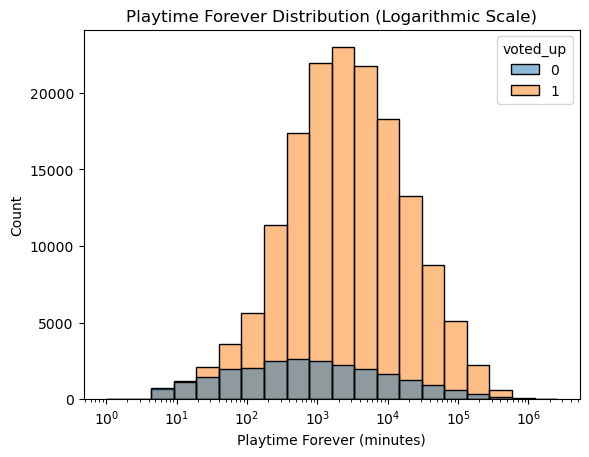

In [66]:
sns.histplot(data=pandas_steam, x='author_playtime_forever', hue ='voted_up',bins=20, log_scale=True)
plt.title('Playtime Forever Distribution (Logarithmic Scale)')
plt.xlabel('Playtime Forever (minutes)')

Text(0.5, 0, 'Playtime Last Two Weeks (minutes)')

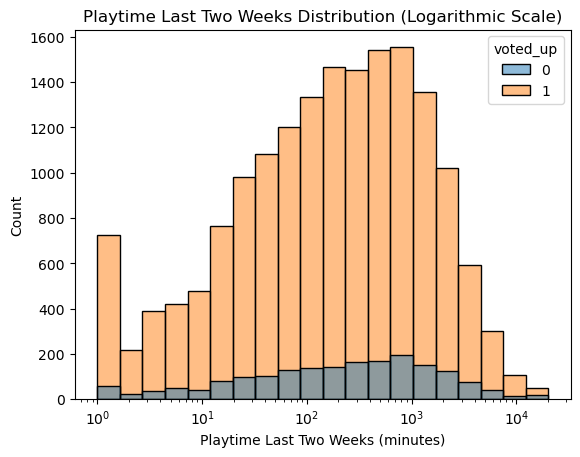

In [67]:
sns.histplot(data=pandas_steam, x='author_playtime_last_two_weeks', hue ='voted_up',bins=20, log_scale=True)
plt.title('Playtime Last Two Weeks Distribution (Logarithmic Scale)')
plt.xlabel('Playtime Last Two Weeks (minutes)')

Text(0.5, 0, 'Playtime at Review (minutes)')

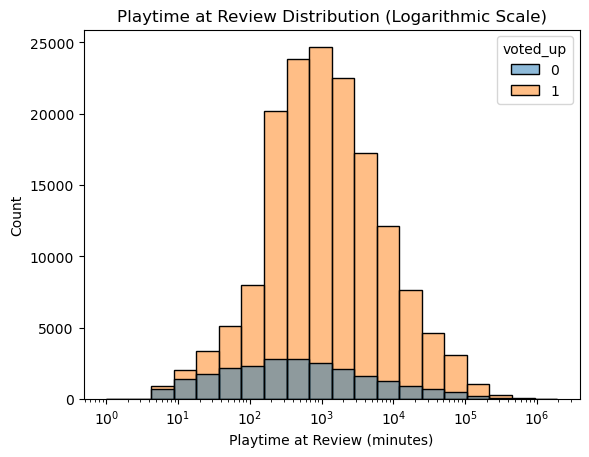

In [68]:
sns.histplot(data=pandas_steam, x='author_playtime_at_review', hue ='voted_up',bins=20, log_scale=True)
plt.title('Playtime at Review Distribution (Logarithmic Scale)')
plt.xlabel('Playtime at Review (minutes)')

4. Plot Data

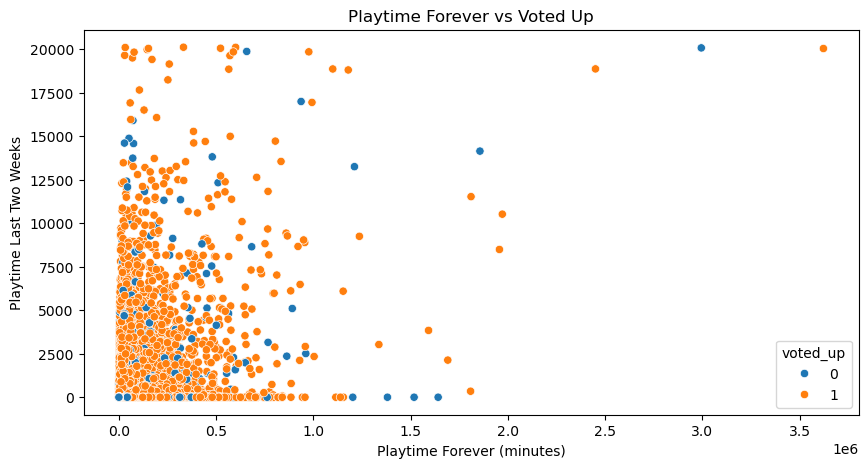

In [44]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pandas_steam, x='author_playtime_forever', y='author_playtime_last_two_weeks', hue='voted_up')
plt.title('Playtime Forever vs Playtime Last Two Weeks')
plt.xlabel('Playtime Forever (minutes)')
plt.ylabel('Playtime Last Two Weeks (minutes)')
plt.show()

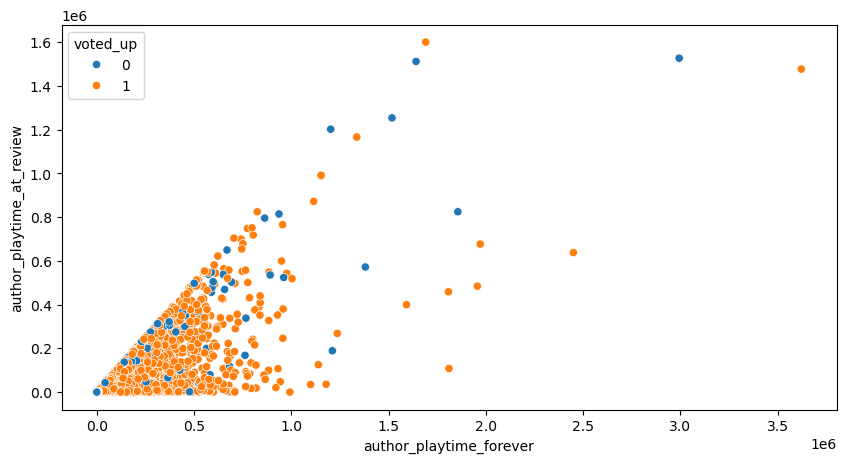

In [46]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pandas_steam, x='author_playtime_forever', y='author_playtime_at_review', hue='voted_up')
plt.title('Playtime Forever vs Playtime at Review')
plt.xlabel('Playtime Forever (minutes)')
plt.ylabel('Playtime at Review (minutes)')
plt.show()

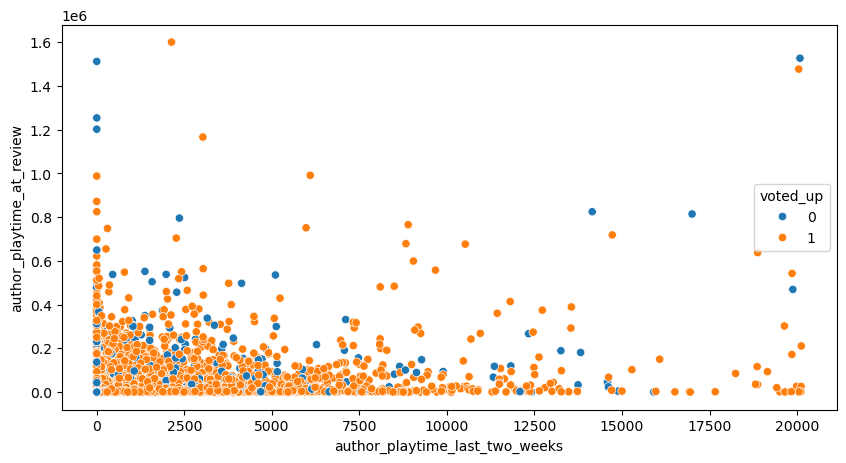

In [47]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pandas_steam, x='author_playtime_last_two_weeks', y='author_playtime_at_review', hue='voted_up')
plt.title('Playtime Forever vs Playtime Last Two Weeks')
plt.xlabel('Playtime Last Two Weeks (minutes)')
plt.ylabel('Playtime at Review (minutes)')
plt.show()